<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/delivery/STEP_4B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git
!cp AML_2025_project4/utils.py .
drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 124 (delta 8), reused 6 (delta 6), pack-reused 106 (from 2)
Receiving objects: 100% (124/124), 21.50 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Mounted at /content/drive


In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import tqdm
from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [ ]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

GAMMA = 0.5

LR = 0.0003296

P = 0.5 # probabilità augmentation

ALPHA_TEACHER = 0.99

THRESHOLD = 0.9

MOMENTUM = 0.85

LOSS_TYPE = "ohem" # "ohem", "ce"

PIXEL_WEIGHT = "threshold_uniform" # "threshold_uniform", "threshold"

SHOW_IMG = False


# Define and instantiate

### Define PIDnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

# Dataset & dataloader

## Dataset definition

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

In [ ]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2

resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])


# The best augmentation from previous step is chosen
alb_aug0 = A.HorizontalFlip(p=P)
alb_aug1 = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))
alb_aug4 = A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=P)

augment = A.Compose([alb_aug4, alb_aug0, alb_aug1])

In [ ]:
def extract_boundary_mask(mask):
    # Check if the input is a PyTorch tensor
    if isinstance(mask, torch.Tensor):
        # Remove batch/channel dimension and move tensor to CPU, then convert to numpy array
        mask_np = mask.squeeze().cpu().numpy()  # Ensure shape is [H, W]
    else:
        # If input is not a tensor, convert it directly to a numpy array
        mask_np = np.array(mask)

    # Convert mask to unsigned 8-bit integer type (required for OpenCV functions)
    mask_np = mask_np.astype(np.uint8)

    # Apply Canny edge detection to find edges in the mask
    # Note: thresholds are very low (0.1, 0.2) to detect subtle boundaries
    edge = cv2.Canny(mask_np, 0.1, 0.2)

    # Define a 3x3 kernel of ones for dilation operation
    kernel = np.ones((3, 3), np.uint8)

    # Crop 6 pixels from each border of the edge map to avoid boundary artifacts
    edge = edge[6:-6, 6:-6]

    # Pad the cropped edge map back to original size with zeros (constant padding)
    edge = np.pad(edge, ((6, 6), (6, 6)), mode='constant')

    # Dilate the edge map to thicken edges and create a boundary region
    boundaries = cv2.dilate(edge, kernel, iterations=1)

    # Convert dilated edges to a binary mask (values > 50 set to 1.0, else 0.0)
    boundaries = (boundaries > 50).astype(np.float32)

    # Convert the boundary mask to a PyTorch tensor with shape [1, H, W]
    boundaries_tensor = torch.from_numpy(boundaries).unsqueeze(0)

    return boundaries_tensor

## Dataset instantiation

In [ ]:
# Create dataset objects
train_and_val_dataset_urban = SegmentationDataset(
    TRAINING_PATH_URBAN + "/images_png",
    TRAINING_PATH_URBAN + "/masks_png",
    transform=resize_transform
)

val_ratio = 0.2
generator = torch.Generator().manual_seed(42)
val_size = int(len(train_and_val_dataset_urban) * val_ratio)
train_size = len(train_and_val_dataset_urban) - val_size

source_dataset, val_dataset = random_split(train_and_val_dataset_urban, [train_size, val_size], generator=generator)
print(f"Source dataset size: {len(source_dataset)}")
print(f"Validation size: {len(val_dataset)}")

target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True)
print(f"Target dataset size: {len(target_dataset)}")

# TEST DATASET
test_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)
print(f"Test dataset size: {len(test_dataset)}")

Source dataset size: 925
Validation size: 231
Target dataset size: 1366
Test dataset size: 992


## Loader instantiation

In [ ]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# TEST DATALOADER
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


### Instantiate model

In [ ]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet_S_ImageNet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 107MB/s]


imagenet-pretrained pidnet weights downloaded


# Training Phase

## Define loss functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
        self.num_outputs = num_outputs
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights

    def _forward(self, pred, target):
        return self.loss(pred, target)

    def forward(self, score, target):

        if self.num_outputs == 1:
            score = [score]

        if len(self.balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
        elif len(score) == 1:
            return self.sb_weights * self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")


# Weighted Binary Cross Entropy per i bordi
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce = 20.0):
        super(BondaryLoss, self).__init__()
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):

        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        loss = bce_loss

        return loss

# PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.sem_loss = CrossEntropyLoss(num_outputs=2, balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3)
        self.bd_loss = BondaryLoss(coeff_bce=lambda_1)

        self.threshold = threshold


    def forward(self, pred_p, pred_main, target, boundary_head, boundary_mask):
        """
        pred_p: output branch P (B, C, H, W)
        pred_main: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """

        loss_s = self.sem_loss([pred_p, pred_main], target) # l_0 e l_2
        loss_b = self.bd_loss(boundary_head, boundary_mask.unsqueeze(1)) # l_1

        # l_3
        filler = torch.ones_like(target) * IGNORE_INDEX
        bd_label = torch.where(F.sigmoid(boundary_head[:,0,:,:])>self.threshold, target, filler)
        loss_sb = self.sem_loss([pred_main], bd_label)


        loss = loss_s + loss_b + loss_sb


        return loss

In [ ]:
class CrossEntropyLoss2dPixelWiseWeighted(nn.Module):
    def __init__(self, weight=None, ignore_index=250, reduction='none'):
        super(CrossEntropyLoss2dPixelWiseWeighted, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target, pixelWiseWeight):
        loss = self.CE(output, target)
        loss = torch.mean(loss * pixelWiseWeight)
        return loss

## Upscaling function

In [ ]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """
    Upscale the model outputs using bilinear interpolation to match the original mask size.
    This typically upsamples from a smaller spatial resolution (e.g., 64x64) to the target size (e.g., 512x512).
    """

    # Get the target height and width from the boundary mask (original resolution)
    h, w = boundary_mask.size(1), boundary_mask.size(2)

    # Get the current height and width of the outputs (assumed same for all outputs)
    ph, pw = outputs[0].size(2), outputs[0].size(3)

    # If output resolution differs from target resolution, perform upscaling
    if ph != h or pw != w:
        # Iterate through all output tensors and resize them to (h, w)
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # If the model uses data augmentation (augment=True), unpack all three output branches
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # Auxiliary, main, and boundary branches
    else:
        # Otherwise, no auxiliary or boundary branch outputs available
        pred_p = None
        pred_main = outputs  # Single main prediction output
        boundary_head = None

    # Return the (possibly upscaled) outputs for further processing
    return pred_p, pred_main, boundary_head

## Instantiate discriminator, optimizers and schedulers

In [ ]:
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

loss_fn = PIDNetLoss(threshold=0.8)
mix_loss = CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX)

print(device)

print(len(target_loader))
print(len(source_loader))

cuda
86
58


# Definition ema model

In [ ]:
def create_ema_model(model):
    """Returns a new model that is used to generate pseudo-labels"""

    ema_model = get_seg_model(cfg, imgnet_pretrained=True)

    for param in ema_model.parameters():
        param.detach_()
    mp = list(model.parameters())
    mcp = list(ema_model.parameters())
    n = len(mp)
    for i in range(0, n):
        mcp[i].data[:] = mp[i].data[:].clone()

    return ema_model


def update_ema_variables(ema_model, model, alpha_teacher, iteration):
    # Use the "true" average until the exponential average is more correct
    alpha_teacher = min(1 - 1 / (iteration + 1), alpha_teacher)

    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    return ema_model

In [ ]:
def generate_class_mask(pred, classes):
    pred, classes = torch.broadcast_tensors(pred.unsqueeze(0), classes.unsqueeze(1).unsqueeze(2))
    N = pred.eq(classes).sum(0)
    return N

In [ ]:
def oneMix(mask, data = None, target = None):
    #Mix
    if not (data is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], data[0])
        data = (stackedMask0*data[0]+(1-stackedMask0)*data[1]).unsqueeze(0)
    if not (target is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], target[0])
        target = (stackedMask0*target[0]+(1-stackedMask0)*target[1]).unsqueeze(0)
    return data, target

In [ ]:
def strong_transform(target, masks_mix, aug = None, data = None):
    data, target = oneMix(masks_mix, data, target)

    if data is not None:
      data_np = data.squeeze(0).cpu().numpy()
    target_np = target.squeeze(0).cpu().numpy()

    if data is not None:
      data_np = np.transpose(data_np, (1, 2, 0))
    target_np = np.transpose(target_np, (1, 2, 0))

    if data is not None:
      augmented = aug(image=data_np, mask=target_np)

      data = augmented['image']
      target = augmented['mask']

      data = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
      target = torch.from_numpy(target).squeeze(-1).unsqueeze(0)  # (1, H, W)
    else:
      target = torch.from_numpy(target_np).squeeze(-1).unsqueeze(0)  # (1, H, W)
      return None, target

    return data, target

## Train

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Move the main model to the target device (GPU or CPU)
model.to(device)

# Create an EMA (Exponential Moving Average) model based on the main model
ema_model = create_ema_model(model)
ema_model.to(device)

# Variable to keep track of the best mean Intersection over Union (mIoU) achieved
record_miou = 0

# Define the number of classes in segmentation task
num_classes = 7
# Initialize the MeanIoU metric for multi-class segmentation,
# per_class=True means it returns IoU per each class separately
miou_classes = MeanIoU(num_classes=num_classes, input_format="index", per_class=True).to(device)

# Main training loop over epochs
for epoch in range(EPOCHS):
    # Print the current learning rate(s) from the scheduler
    print(scheduler.get_last_lr())
    loss_raw_value = 0
    total_train_samples = 0

    model.train()      # Set model to training mode
    ema_model.train()  # Also set the EMA model to training mode

    # Zip together the source and target loaders to do semi-supervised training
    train_loader = zip(source_loader, target_loader)
    num_batches = min(len(source_loader), len(target_loader))

    # Initialize tqdm progress bar for the epoch training
    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1} [Training]")

    # Iterate over batches
    for i, (source_batch, target_batch) in pbar:
        optimizer.zero_grad()  # Zero the gradients before backpropagation

        # Unpack the source batch: inputs, labels, and boundary masks, then move to device
        X_source, y_source, boundary_mask_source = source_batch
        X_source, y_source, boundary_mask_source = X_source.to(device), y_source.to(device), boundary_mask_source.to(device)

        # Unpack the target batch (unlabeled), inputs and boundary masks, move to device
        X_target, boundary_mask_target = target_batch
        X_target, boundary_mask_target = X_target.to(device), boundary_mask_target.to(device)

        # Forward pass on labeled source data with main model
        outputs_s = model(X_source)

        # Upscaling function processes outputs, boundary masks, and returns several predictions
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs_s, boundary_mask=boundary_mask_source, model=model)

        # Compute loss on labeled data using custom loss function
        loss_labled = loss_fn(pred_p, pred_main, y_source, boundary_head, boundary_mask_source)

        # If using Online Hard Example Mining (OHEM), take mean loss
        if(LOSS_TYPE == "ohem"):
          loss_labled = torch.mean(loss_labled)

        # Forward pass on unlabeled target data with EMA teacher model
        outputs_t = ema_model(X_target)

        # Upscale teacher outputs and get main predictions
        _, pred_main, _ = Upscaling(outputs=outputs_t, boundary_mask=boundary_mask_target, model=ema_model)

        # Compute softmax probabilities and extract pseudo-labels
        probs_t = torch.softmax(pred_main.detach(), dim=1)
        max_probs, pseudo_labels = torch.max(probs_t, dim=1)

        MixMasks = []

        # For each image in source batch, randomly select half of the unique classes (excluding ignore index)
        for image_i in range(X_source.shape[0]):
          classes = torch.unique(y_source[image_i])
          classes = classes[classes != -1]
          nclasses = classes.shape[0]

          # Randomly sample half of the classes (rounded up if odd)
          classes = (classes[torch.Tensor(np.random.choice(nclasses, int((nclasses + nclasses % 2) / 2), replace=False)).long()]).cuda()

          # Generate a mask that selects only the chosen classes for mixing
          MixMask = generate_class_mask(y_source[image_i], classes).unsqueeze(0).cuda()
          MixMasks.append(MixMask)

        mixed_imgs = []
        mixed_labels = []
        mixed_boundary_masks = []

        # For each image in the batch, perform strong data augmentation and mixing between source and target
        for image_i in range(X_source.shape[0]):
          # Concatenate source and target images and their labels/pseudo-labels along batch dimension
          data = torch.cat((X_source[image_i].unsqueeze(0), X_target[image_i].unsqueeze(0)))
          labels = torch.cat((y_source[image_i].unsqueeze(0), pseudo_labels[image_i].unsqueeze(0)))

          # Apply strong augmentation mixing on data, labels, and masks
          data, mask = strong_transform(
              aug=augment,
              data=data,
              target=labels,
              masks_mix=[MixMasks[image_i]]
          )

          # Extract boundary masks from the augmented mask
          boundary_mask_mix = extract_boundary_mask(mask)

          mixed_imgs.append(data)
          mixed_labels.append(mask)
          mixed_boundary_masks.append(boundary_mask_mix)

        # Optionally visualize the first batch of mixed images, labels, and boundaries
        if SHOW_IMG == True:
          if i == 0:
            fig, axs = plt.subplots(2, 3, figsize=(24, 10))

            for j in range(2):
              axs[j, 0].imshow(mixed_imgs[j].squeeze().permute(1, 2, 0).cpu().detach().numpy())
              axs[j, 0].set_title("IMG")
              axs[j, 0].axis('off')

              axs[j, 1].imshow(mixed_labels[j].permute(1, 2, 0).cpu().detach().numpy())
              axs[j, 1].set_title("Labels")
              axs[j, 1].axis('off')

              axs[j, 2].imshow(mixed_boundary_masks[j].permute(1, 2, 0).cpu().detach().numpy())
              axs[j, 2].set_title("Boundary")
              axs[j, 2].axis('off')

            plt.tight_layout()
            plt.show()

        # Rebuild full batch tensors from list of mixed images, labels, and boundary masks
        inputs_mix = torch.cat(mixed_imgs, dim=0).to(device)
        targets_mix = torch.cat(mixed_labels, dim=0).to(device)
        boundary_masks_mix = torch.cat(mixed_boundary_masks, dim=0).to(device)

        # Forward pass on mixed inputs with the main model
        outputs_mix = model(inputs_mix)

        # Upscaling outputs and get predictions for the mixed inputs
        pred_p_mix, pred_main_mix, boundary_head_mix = Upscaling(outputs=outputs_mix, boundary_mask=boundary_masks_mix, model=model)

        # Compute pixel-wise weights for unlabeled pixels based on confidence threshold
        if PIXEL_WEIGHT == "threshold_uniform":
          # Use uniform weight scaled by fraction of pixels above confidence threshold
          unlabeled_weight = torch.sum(max_probs.ge(0.968).long() == 1).item() / np.size(np.array(targets_mix.cpu()))
          pixelWiseWeight = unlabeled_weight * torch.ones(max_probs.shape).cuda()
        else:
          # Binary mask of pixels with confidence above threshold
          pixelWiseWeight = max_probs.ge(THRESHOLD).float().cuda()

        # Create a tensor of ones weights for labeled pixels
        onesWeights = torch.ones((pixelWiseWeight.shape)).cuda()

        pixelWiseWeight_mix = []

        # For each image in the batch, mix pixel weights according to MixMasks and strong transforms
        for image_i in range(X_source.shape[0]):
            weights_pair = torch.cat((onesWeights[image_i].unsqueeze(0), pixelWiseWeight[image_i].unsqueeze(0)))

            _, mixed_weights = strong_transform(
                target=weights_pair,
                masks_mix=[MixMasks[image_i]]
            )

            pixelWiseWeight_mix.append(mixed_weights)

        # Concatenate pixel-wise weights for the batch
        pixelWiseWeight_mix = torch.cat(pixelWiseWeight_mix, dim=0).to(device)  # shape: [B, H, W]

        # Compute segmentation loss on mixed inputs, weighted by pixel confidence
        loss_seg_mix = mix_loss(pred_main_mix, targets_mix, pixelWiseWeight_mix)

        # Total loss is sum of labeled loss + mixed unlabeled loss
        loss_overall = loss_seg_mix + loss_labled

        # Backpropagation and optimization step
        loss_overall.backward()
        optimizer.step()

        # Update the EMA teacher model parameters using moving average
        ema_model = update_ema_variables(ema_model=ema_model, model=model, alpha_teacher=ALPHA_TEACHER, iteration=(epoch * num_batches + i))

        # Track running loss and sample count for logging
        loss_raw_value += loss_overall.item()
        total_train_samples += X_target.size(0)

        # Update progress bar with current average loss
        pbar.set_postfix({
            "Loss_seg": f"{loss_raw_value / (i+1):.4f}",
        })

    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary")
    print(f"  → Segmentation Source Loss (RAW) : {loss_raw_value / total_train_samples:.4f}")

    # ---------------------- VALIDATION ----------------------

    model.eval()  # Set model to evaluation mode
    val_loss = 0
    miou_classes.reset()  # Reset MeanIoU metric state
    total_val_samples = 0

    # Disable gradient computation for validation
    with torch.inference_mode():
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1} [Validation]")

        # Loop over validation batches
        for batch, (X_val, y_val, boundary_mask) in pbar_val:
            X_val, y_val, boundary_mask = X_val.to(device), y_val.to(device), boundary_mask.to(device)

            # Forward pass on validation inputs
            outputs = model(X_val)
            pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

            # Compute validation loss
            loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

            if(LOSS_TYPE == "ohem"):
              loss = torch.mean(loss)

            val_loss += loss.item()
            total_val_samples += X_val.size(0)

            # Compute predicted labels by taking argmax over classes
            preds = pred_main.argmax(dim=1)
            # Create mask to ignore invalid pixels (e.g., -1 labels)
            valid_mask = (y_val >= 0) & (y_val < num_classes)
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            # Update the MeanIoU metric with current batch results
            miou_classes.update(preds_flat, targets_flat)

            # Update progress bar with current validation loss and mIoU
            pbar_val.set_postfix({
                "Val_Loss": f"{val_loss / (batch+1):.4f}",
                "mIoU": f"{miou_classes.compute().mean():.4f}"
            })

    # Compute average validation loss and final mean IoU per class
    avg_val_loss = val_loss / total_val_samples
    miou_per_class = miou_classes.compute()
    miou = miou_per_class.mean()

    # Save model checkpoint if performance improves
    if record_miou is None or miou > record_miou:
        best_model_path = f"/content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best mIoU model saved: {best_model_path}")
        record_miou = miou

    # Print validation summary with per-class IoU
    print(f"\n→ Validation Loss: {avg_val_loss:.4f}")
    print(f"→ Overall mIoU: {miou:.4f}")
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step(miou)

[0.0003296]


Epoch 1 [Training]: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s, Loss_seg=13.9393]


Epoch 1/20 Summary
  → Segmentation Source Loss (RAW) : 0.8712



Epoch 1 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s, Val_Loss=8.9685, mIoU=0.1754]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.5824
→ Overall mIoU: 0.1754
  → background IoU: 0.3533
  → building IoU: 0.2430
  → road IoU: 0.1387
  → water IoU: 0.2323
  → barren IoU: 0.1393
  → forest IoU: 0.0899
  → agriculture IoU: 0.0314
[0.0003296]


Epoch 2 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=9.2842]


Epoch 2/20 Summary
  → Segmentation Source Loss (RAW) : 0.5803



Epoch 2 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s, Val_Loss=7.6075, mIoU=0.2079]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.4940
→ Overall mIoU: 0.2079
  → background IoU: 0.3855
  → building IoU: 0.2575
  → road IoU: 0.1926
  → water IoU: 0.2755
  → barren IoU: 0.1986
  → forest IoU: 0.1146
  → agriculture IoU: 0.0312
[0.0003296]


Epoch 3 [Training]: 100%|██████████| 58/58 [00:43<00:00,  1.35it/s, Loss_seg=7.6786]


Epoch 3/20 Summary
  → Segmentation Source Loss (RAW) : 0.4799



Epoch 3 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s, Val_Loss=6.4454, mIoU=0.2325]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.4185
→ Overall mIoU: 0.2325
  → background IoU: 0.4095
  → building IoU: 0.2877
  → road IoU: 0.2310
  → water IoU: 0.3083
  → barren IoU: 0.1851
  → forest IoU: 0.1641
  → agriculture IoU: 0.0416
[0.0003296]


Epoch 4 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, Loss_seg=6.7953]


Epoch 4/20 Summary
  → Segmentation Source Loss (RAW) : 0.4247



Epoch 4 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s, Val_Loss=5.9482, mIoU=0.2573]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3862
→ Overall mIoU: 0.2573
  → background IoU: 0.4193
  → building IoU: 0.3064
  → road IoU: 0.2549
  → water IoU: 0.3473
  → barren IoU: 0.2322
  → forest IoU: 0.2005
  → agriculture IoU: 0.0403
[0.0003296]


Epoch 5 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s, Loss_seg=6.3018]


Epoch 5/20 Summary
  → Segmentation Source Loss (RAW) : 0.3939



Epoch 5 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s, Val_Loss=5.5480, mIoU=0.2626]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3603
→ Overall mIoU: 0.2626
  → background IoU: 0.4534
  → building IoU: 0.3010
  → road IoU: 0.2839
  → water IoU: 0.3595
  → barren IoU: 0.1695
  → forest IoU: 0.2168
  → agriculture IoU: 0.0537
[0.0003296]


Epoch 6 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, Loss_seg=6.0136]


Epoch 6/20 Summary
  → Segmentation Source Loss (RAW) : 0.3758



Epoch 6 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s, Val_Loss=5.2725, mIoU=0.2829]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3424
→ Overall mIoU: 0.2829
  → background IoU: 0.4487
  → building IoU: 0.3180
  → road IoU: 0.2941
  → water IoU: 0.3901
  → barren IoU: 0.2899
  → forest IoU: 0.1815
  → agriculture IoU: 0.0579
[0.0003296]


Epoch 7 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s, Loss_seg=5.8657]


Epoch 7/20 Summary
  → Segmentation Source Loss (RAW) : 0.3666



Epoch 7 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s, Val_Loss=5.1435, mIoU=0.2886]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3340
→ Overall mIoU: 0.2886
  → background IoU: 0.4655
  → building IoU: 0.3329
  → road IoU: 0.3147
  → water IoU: 0.3874
  → barren IoU: 0.2258
  → forest IoU: 0.2215
  → agriculture IoU: 0.0727
[0.0003296]


Epoch 8 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, Loss_seg=5.6000]


Epoch 8/20 Summary
  → Segmentation Source Loss (RAW) : 0.3500



Epoch 8 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s, Val_Loss=4.9657, mIoU=0.2980]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3224
→ Overall mIoU: 0.2980
  → background IoU: 0.4767
  → building IoU: 0.3391
  → road IoU: 0.3265
  → water IoU: 0.4120
  → barren IoU: 0.2448
  → forest IoU: 0.2186
  → agriculture IoU: 0.0686
[0.0003296]


Epoch 9 [Training]: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s, Loss_seg=5.5175]


Epoch 9/20 Summary
  → Segmentation Source Loss (RAW) : 0.3448



Epoch 9 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s, Val_Loss=4.9168, mIoU=0.3065]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3193
→ Overall mIoU: 0.3065
  → background IoU: 0.4810
  → building IoU: 0.3367
  → road IoU: 0.3438
  → water IoU: 0.4160
  → barren IoU: 0.2618
  → forest IoU: 0.2247
  → agriculture IoU: 0.0815
[0.0003296]


Epoch 10 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s, Loss_seg=5.3583]


Epoch 10/20 Summary
  → Segmentation Source Loss (RAW) : 0.3349



Epoch 10 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s, Val_Loss=4.8975, mIoU=0.3174]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3180
→ Overall mIoU: 0.3174
  → background IoU: 0.4756
  → building IoU: 0.3638
  → road IoU: 0.3494
  → water IoU: 0.4174
  → barren IoU: 0.3037
  → forest IoU: 0.2370
  → agriculture IoU: 0.0746
[0.0003296]


Epoch 11 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=5.3583]


Epoch 11/20 Summary
  → Segmentation Source Loss (RAW) : 0.3349



Epoch 11 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s, Val_Loss=4.9425, mIoU=0.3225]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3209
→ Overall mIoU: 0.3225
  → background IoU: 0.4782
  → building IoU: 0.3664
  → road IoU: 0.3655
  → water IoU: 0.4228
  → barren IoU: 0.2898
  → forest IoU: 0.2467
  → agriculture IoU: 0.0881
[0.0003296]


Epoch 12 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s, Loss_seg=5.2366]


Epoch 12/20 Summary
  → Segmentation Source Loss (RAW) : 0.3273



Epoch 12 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s, Val_Loss=4.7383, mIoU=0.3282]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3077
→ Overall mIoU: 0.3282
  → background IoU: 0.4928
  → building IoU: 0.3608
  → road IoU: 0.3804
  → water IoU: 0.4412
  → barren IoU: 0.3000
  → forest IoU: 0.2246
  → agriculture IoU: 0.0976
[0.0003296]


Epoch 13 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, Loss_seg=5.1231]


Epoch 13/20 Summary
  → Segmentation Source Loss (RAW) : 0.3202



Epoch 13 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s, Val_Loss=4.6984, mIoU=0.3424]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.3051
→ Overall mIoU: 0.3424
  → background IoU: 0.4857
  → building IoU: 0.3797
  → road IoU: 0.3734
  → water IoU: 0.4581
  → barren IoU: 0.3254
  → forest IoU: 0.2748
  → agriculture IoU: 0.0996
[0.0003296]


Epoch 14 [Training]: 100%|██████████| 58/58 [00:41<00:00,  1.38it/s, Loss_seg=5.0772]


Epoch 14/20 Summary
  → Segmentation Source Loss (RAW) : 0.3173



Epoch 14 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s, Val_Loss=4.5893, mIoU=0.3376]


→ Validation Loss: 0.2980
→ Overall mIoU: 0.3376
  → background IoU: 0.4953
  → building IoU: 0.3713
  → road IoU: 0.3927
  → water IoU: 0.4436
  → barren IoU: 0.2598
  → forest IoU: 0.2904
  → agriculture IoU: 0.1101
[0.0003296]



Epoch 15 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=5.0289]


Epoch 15/20 Summary
  → Segmentation Source Loss (RAW) : 0.3143



Epoch 15 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s, Val_Loss=4.6764, mIoU=0.3414]


→ Validation Loss: 0.3037
→ Overall mIoU: 0.3414
  → background IoU: 0.4970
  → building IoU: 0.3736
  → road IoU: 0.3943
  → water IoU: 0.4561
  → barren IoU: 0.2764
  → forest IoU: 0.2916
  → agriculture IoU: 0.1007
[0.0003296]



Epoch 16 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=4.9719]


Epoch 16/20 Summary
  → Segmentation Source Loss (RAW) : 0.3107



Epoch 16 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s, Val_Loss=4.5525, mIoU=0.3450]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.2956
→ Overall mIoU: 0.3450
  → background IoU: 0.5057
  → building IoU: 0.3834
  → road IoU: 0.3950
  → water IoU: 0.4934
  → barren IoU: 0.2869
  → forest IoU: 0.2439
  → agriculture IoU: 0.1068
[0.0003296]


Epoch 17 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s, Loss_seg=4.9426]


Epoch 17/20 Summary
  → Segmentation Source Loss (RAW) : 0.3089



Epoch 17 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s, Val_Loss=4.5197, mIoU=0.3539]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.2935
→ Overall mIoU: 0.3539
  → background IoU: 0.5049
  → building IoU: 0.3985
  → road IoU: 0.4095
  → water IoU: 0.4830
  → barren IoU: 0.3010
  → forest IoU: 0.2781
  → agriculture IoU: 0.1025
[0.0003296]


Epoch 18 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=4.9488]


Epoch 18/20 Summary
  → Segmentation Source Loss (RAW) : 0.3093



Epoch 18 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s, Val_Loss=4.5531, mIoU=0.3668]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.2957
→ Overall mIoU: 0.3668
  → background IoU: 0.5043
  → building IoU: 0.3976
  → road IoU: 0.4187
  → water IoU: 0.4909
  → barren IoU: 0.3311
  → forest IoU: 0.3031
  → agriculture IoU: 0.1217
[0.0003296]


Epoch 19 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s, Loss_seg=4.8640]


Epoch 19/20 Summary
  → Segmentation Source Loss (RAW) : 0.3040



Epoch 19 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s, Val_Loss=4.5290, mIoU=0.3588]


→ Validation Loss: 0.2941
→ Overall mIoU: 0.3588
  → background IoU: 0.5072
  → building IoU: 0.4026
  → road IoU: 0.4180
  → water IoU: 0.4942
  → barren IoU: 0.2978
  → forest IoU: 0.2787
  → agriculture IoU: 0.1131
[0.0003296]



Epoch 20 [Training]: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s, Loss_seg=4.8588]


Epoch 20/20 Summary
  → Segmentation Source Loss (RAW) : 0.3037



Epoch 20 [Validation]: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s, Val_Loss=4.4125, mIoU=0.3709]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_aug_split.pth

→ Validation Loss: 0.2865
→ Overall mIoU: 0.3709
  → background IoU: 0.5134
  → building IoU: 0.4109
  → road IoU: 0.4279
  → water IoU: 0.4932
  → barren IoU: 0.3407
  → forest IoU: 0.2976
  → agriculture IoU: 0.1128


## Test

In [ ]:
class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES


cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

best_model_weights = torch.load(best_model_path)

try:
  model.load_state_dict(torch.load(best_model_path))
except:
  print(list(torch.load(best_model_path).keys())[:5])

model.to(device)

PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

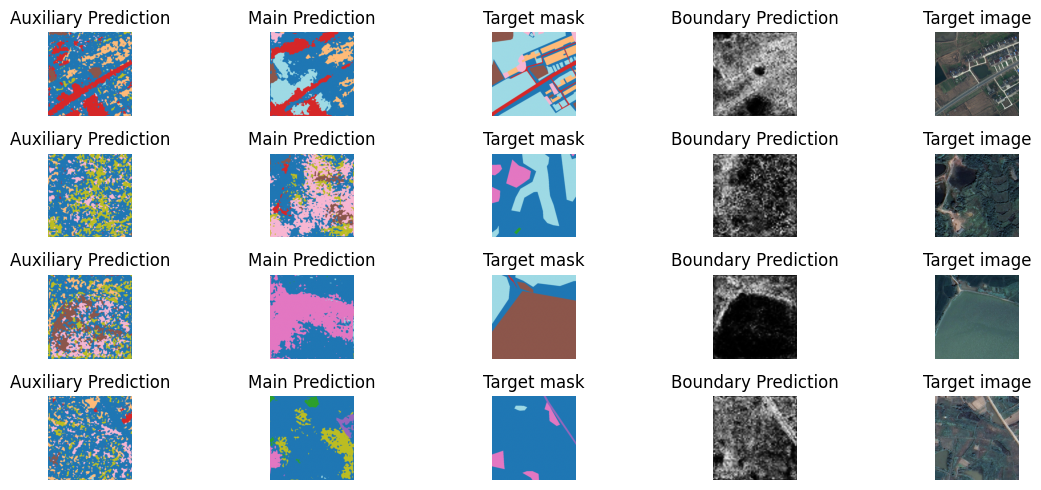

tensor(0.2083, device='cuda:0')
Test Loss: 0.3459036580977901 | mIoU: 0.20830495655536652 | Total test samples seen: 992
  → background IoU: 0.4001
  → building IoU: 0.2570
  → road IoU: 0.2046
  → water IoU: 0.2811
  → barren IoU: 0.0315
  → forest IoU: 0.0887
  → agriculture IoU: 0.1951


In [ ]:
# ****************************** Test ******************************
from torchmetrics.segmentation import MeanIoU
import matplotlib.pyplot as plt

num_classes = 7
# Initialize MeanIoU metric to compute per-class IoU, input_format "index" means predictions and targets are class indices
miou_classes = MeanIoU(num_classes=num_classes, input_format="index", per_class=True).to(device)

model.eval()  # Set model to evaluation mode
test_loss = 0
miou_classes.reset()  # Reset metric state before testing
total_test_samples = 0  # Counter for total number of samples processed

with torch.inference_mode():  # Disable gradient computation for inference speed and memory saving
    for batch, (X_test, y_test, boundary_mask) in enumerate(test_loader):
        # Move data to the device (GPU/CPU)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        boundary_mask = boundary_mask.to(device)

        # Forward pass through the model to get outputs
        outputs = model(X_test)

        # Apply your upscaling function to get different predictions
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

        # Plot the first batch results for visualization
        if batch == 0:
            fig, axs = plt.subplots(4, 5, figsize=(12, 5))

            for j in range(4):
                # Auxiliary prediction visualization (argmax to get predicted class per pixel)
                axs[j, 0].imshow(pred_p[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
                axs[j, 0].set_title("Auxiliary Prediction")
                axs[j, 0].axis('off')

                # Main prediction visualization
                axs[j, 1].imshow(pred_main[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
                axs[j, 1].set_title("Main Prediction")
                axs[j, 1].axis('off')

                # Ground truth target mask visualization
                axs[j, 2].imshow(y_test[j].cpu().detach().numpy(), cmap='tab20')
                axs[j, 2].set_title("Target mask")
                axs[j, 2].axis('off')

                # Boundary prediction visualization (sigmoid for probabilities, grayscale)
                axs[j, 3].imshow(boundary_head[j].cpu().detach().sigmoid().squeeze(0).numpy(), cmap='gray')
                axs[j, 3].set_title("Boundary Prediction")
                axs[j, 3].axis('off')

                # Original input image visualization
                axs[j, 4].imshow(X_test[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
                axs[j, 4].set_title("Target image")
                axs[j, 4].axis('off')

            plt.tight_layout()
            plt.show()

        # Compute the loss for the batch, using your custom loss function
        loss = loss_fn(pred_p, pred_main, y_test, boundary_head, boundary_mask)

        # If loss type is Online Hard Example Mining, average the loss tensor
        if LOSS_TYPE == "ohem":
            loss = loss.mean()

        # Accumulate the loss value (assumes loss.item() is mean loss per batch)
        test_loss += loss.item()

        # Accumulate the number of samples processed so far
        total_test_samples += X_test.size(0)

        # Get predicted classes by taking argmax over class dimension
        preds = pred_main.argmax(dim=1)

        # Create a mask for valid pixels (labels in [0, num_classes-1])
        valid_mask = (y_test >= 0) & (y_test < num_classes)

        # Flatten predictions and targets only for valid pixels for metric update
        preds_flat = preds[valid_mask]
        targets_flat = y_test[valid_mask]

        # Update the MeanIoU metric with current batch predictions and targets
        miou_classes.update(preds_flat, targets_flat)

# Calculate average test loss (note: consider dividing by number of batches instead if loss is batch-mean)
avg_test_loss = test_loss / total_test_samples

# Compute per-class IoU and overall mean IoU
miou_per_class = miou_classes.compute()
miou = miou_per_class.mean()

print(miou)  # Print overall mean IoU

print(f"Test Loss: {avg_test_loss} | mIoU: {miou} | Total test samples seen: {total_test_samples}")

# Print IoU per class with class names (assuming sem_class_to_idx is a dict mapping class names to indices)
for i, iou in enumerate(miou_per_class):
    # Find class name by index lookup
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")